Keep all the imports at the beginning of the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/DTU/Social Graphs/")

import pickle
import re
import statistics as st
import string 
import typing as t
from tqdm import tqdm

import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import fa2
try:
    import powerlaw
except ImportError:
    !pip install powerlaw
    import powerlaw

from collections import(Counter, defaultdict)
from community import community_louvain 

from wordcloud import WordCloud



In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Basic Stats

In [ ]:
class Character:
    """Class containing information about marvel/dc character"""
    
    def __init__(self, name: str, universe: str, data: str):
        self.name = name
        self.universe = universe
        self.data = data
        self.connections = None
        self.n_words = 0
    
    def inspect_data(self, valid_names: t.List[str]):
        """
        Inspect data looking for connections and number of words.
        
        Parameters
        ----------
        valid_names : List of valid character names used in connections search
        """

        re_wikilink = re.compile(r"(?:\[\[)(.*?)(?:\]\])")
        self.connections = set(filter(lambda name: name in valid_names, re_wikilink.findall(self.data)))
        self.n_words = len(re.findall(r"\b\w+\b", self.data))
    
    def __str__(self):
        return str(self.__dict__)
    
class Characters:
    """A wrapper class for storing information about marvel/dc characters"""

    def __init__(self, characters: t.List[Character]):
        self.characters = characters
    
    @classmethod
    def from_dirs(cls, *args):
        """
        Initialize an object using files in provided directories.

        Parameters
        ----------
        args : directories with characters files. They must be named
        the same way as the universe characters are from.

        """
        characters = []
        char_names = []
        paths = []

        # collect files from all supplied directories
        for dir in args:
            if not os.path.isdir(dir):
                print(f"{dir} is not a directory, skipping")
                continue
            for char_file in os.listdir(dir):
                if not os.path.isfile(os.path.join(dir, char_file)):
                    print(f"{path} is not a file, skipping")
                    continue
                # save both path to file and character name for convenienve
                paths.append((dir, char_file))
                char_names.append(char_file.replace(".txt", ""))

        print("reading character files")
        # read content of all files
        for char_name, path in tqdm(zip(char_names, paths), total=len(paths)):
                try:
                    with open(os.path.join(*path), "r", encoding="utf-8") as rfile:
                        # initialize a character and append it to lisr of characters
                        char = Character(
                            name = char_name,
                            universe = path[0],
                            data = rfile.read(),
                        )
                        # look for connections and count words in a document
                        char.inspect_data(char_names)
                        characters.append(char)
                except IOError:
                    print(f"something went wrong when reading {os.path.join(*path)}")
        return cls(characters)

    def get(self, name: str, default=None) -> Character:
        """
        Get a character if present, otherwise default value.

        Parameters
        ----------
        name:
            Character name
        default: [None]
            Default return value if character not found
        
        Returns
        -------
        [Character|default]
        """

        for char in self.characters:
            if char.name == name:
                return char
        return default
    
    @property
    def names(self):
        """Return list of characters names"""
        return [char.name for char in self.characters]
    
    @property
    def marvel(self):
        """Return list of marvel characters only"""
        return [char for char in self.characters if char.universe == "marvel"]
    

    @property
    def dc(self):
        """Return list of dc characters only"""
        return [char for char in self.characters if char.universe == "dc"]

In [ ]:
characters = Characters.from_dirs("marvel", "dc")

reading character files


100%|██████████| 2317/2317 [02:05<00:00, 18.48it/s]


Construct a DiGraph of marvel and DC connections

In [ ]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """

    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")

In [ ]:
# initialize universe directional graph
Universe = nx.DiGraph()
for character in characters.characters:
    # add node with metadata for each character
    Universe.add_node(character.name, universe=character.universe, n_words=character.n_words)
    for connection in character.connections:
        if connection not in Universe:
            # get character object by its name
            mate = characters.get(connection)
            # if it exists and character connection is not pointing to itself, add node
            # for that connection (mate)
            if mate and mate != character.name:
                Universe.add_node(
                    connection,
                    universe=mate.name,
                    n_words=mate.n_words
                )
        # add edge between character and its connection if it's not a self loop
        if connection != character.name:
            Universe.add_edge(character.name, connection)

In [ ]:
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")

Number of nodes: 2317
Number of links: 14148


In [ ]:
# save graph as an edgelist
nx.write_edgelist(Universe, "/universe.edgelist")

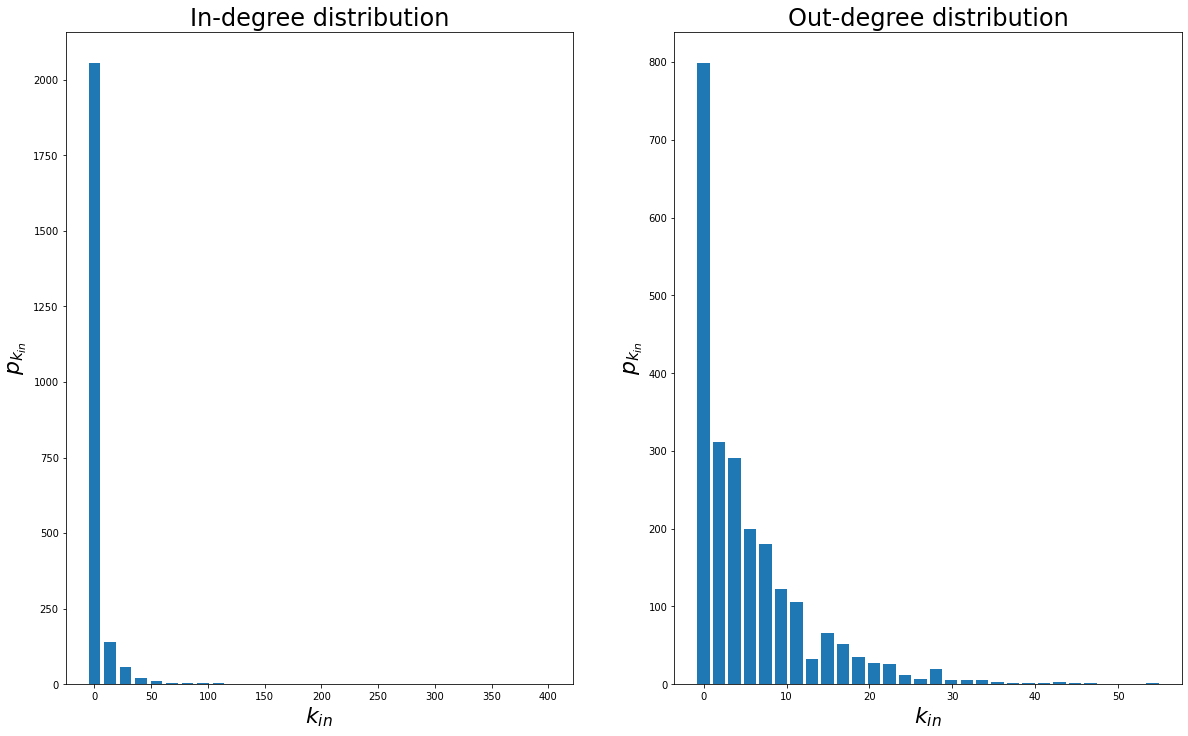

In [ ]:
in_degrees = [d for _, d in Universe.in_degree()]
out_degrees = [d for _, d in Universe.out_degree()]

in_hist, in_bins = np.histogram(in_degrees, 30)
out_hist, out_bins = np.histogram(out_degrees, 30)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))
# in degree
bars = ax[0].bar(in_bins[:-1], in_hist, width=10)
ax[0].set_title("In-degree distribution", size=24)
ax[0].set_xlabel("$k_{in}$", size=22)
ax[0].set_ylabel("$p_{k_{in}}$", size=22)
# out degree
ax[1].bar(out_bins[:-1], out_hist, width=1.5)
ax[1].set_title("Out-degree distribution", size=24)
ax[1].set_xlabel("$k_{in}$", size=22)
ax[1].set_ylabel("$p_{k_{in}}$", size=22)
plt.show()

In [ ]:
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

==================== Universe stats ====================

In degree: {'mean': 6.10617177384549, 'median': 0, 'mode': 0, 'min': 0, 'max': 410}
Out degree: {'mean': 6.10617177384549, 'median': 4, 'mode': 0, 'min': 0, 'max': 56}


Slope of the incoming degree distribution

In [ ]:
in_degrees = [degree[1] for degree in Universe.in_degree() if degree[1] > 0]
in_degree_alpha = powerlaw.Fit(in_degrees).alpha
print(f"In degree slope: {in_degree_alpha:.2f}")

Calculating best minimal value for power law fit
In degree slope: 2.54


In [ ]:
YELLOW = "#fce700"
BLUE = "#00d7fc"
GRAY = "#000000"

largest_component = sorted(nx.weakly_connected_components(Universe), key=len, reverse=True)[0]
Undirected_universe_lc = Universe.subgraph(largest_component).to_undirected()
# set node colors
node_color = ["#e6253e" if Undirected_universe_lc.nodes[node]["universe"] == "marvel" else "#000000" for node in Undirected_universe_lc.nodes]
# set node size
node_size = [Undirected_universe_lc.degree(node)//3 for node in Undirected_universe_lc.nodes]
# edge color
edge_color = []
for node1, node2 in Undirected_universe_lc.edges():
    universe1 = Undirected_universe_lc.nodes[node1]["universe"]
    universe2 = Undirected_universe_lc.nodes[node2]["universe"]
    if universe1 == universe2:
        if universe1 == "marvel":
            edge_color.append(YELLOW)
        else:
            edge_color.append(BLUE)
    else:
        edge_color.append(GRAY)


In [ ]:
# use Force Atlas 2
if not os.path.exists("assignment2/data/"):
    os.makedirs("assignment2/data")

FA_POSITIONS = "assignment2/data/positions.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

Network plot using Force Atlas algorithm

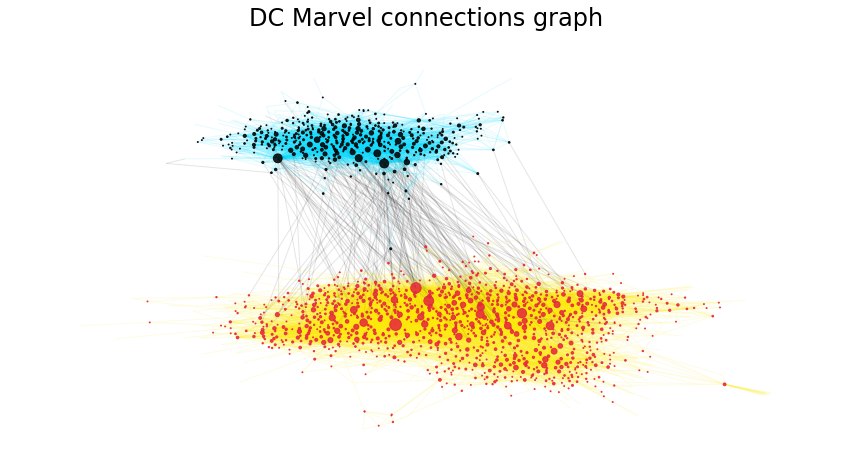

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc, positions, node_color=node_color, node_size=node_size, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc, positions, edge_color=edge_color, alpha=0.1, ax=ax)
ax.set_title("DC Marvel connections graph", size=24)
ax.axis("off")
plt.show()

### Part 2

In [ ]:
universe = Universe.to_undirected()


In [ ]:

def modularity(graph, tag, communities):

    # L : number of links in the network
    l = len(list(graph.edges()))

    # initialize modularity sum
    m = 0
    for community in communities:
        nodes = (node for node, data in graph.nodes(data=True) if data.get(tag) == community)
        # subgraph one community
        comm_subgraph = graph.subgraph(nodes)
        # L_c : number of links within community
        l_c = len(list(comm_subgraph.edges()))
        # k_c : total degree of the nodes in the community
        k_c = sum([deg for _, deg in comm_subgraph.degree()])
        m += l_c / l - (k_c / (2 * l))**2
    
    return m

print(modularity(universe, "universe", ["marvel", "dc"]))

0.38882573094830897


In [ ]:
# Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

marvel_subgraph = universe.subgraph(node for node, data in universe.nodes(data=True) if data.get("universe") == "marvel")
marvel_subgraph = marvel_subgraph.subgraph(node for node in marvel_subgraph.nodes() if marvel_subgraph.degree(node) > 0)
marvel_subgraph = marvel_subgraph.subgraph(sorted(nx.connected_components(marvel_subgraph), key=len, reverse=True)[0])

degrees = [deg for _, deg in marvel_subgraph.degree()]

In [ ]:
# compute the best partition 
partition = community_louvain.best_partition(marvel_subgraph)
# compute graph positions
positions = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(marvel_subgraph, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:41<00:00, 48.61it/s]

BarnesHut Approximation  took  12.05  seconds
Repulsion forces  took  25.76  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.42  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


In [ ]:
node_size = [marvel_subgraph.degree(node) for node in marvel_subgraph.nodes]

In [ ]:
# number of communities
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [48]:
count = Counter(partition.values())
print(count)

Counter({2: 324, 4: 261, 3: 220, 1: 209, 0: 103, 7: 71, 5: 68, 6: 25, 8: 16, 10: 10, 9: 4})


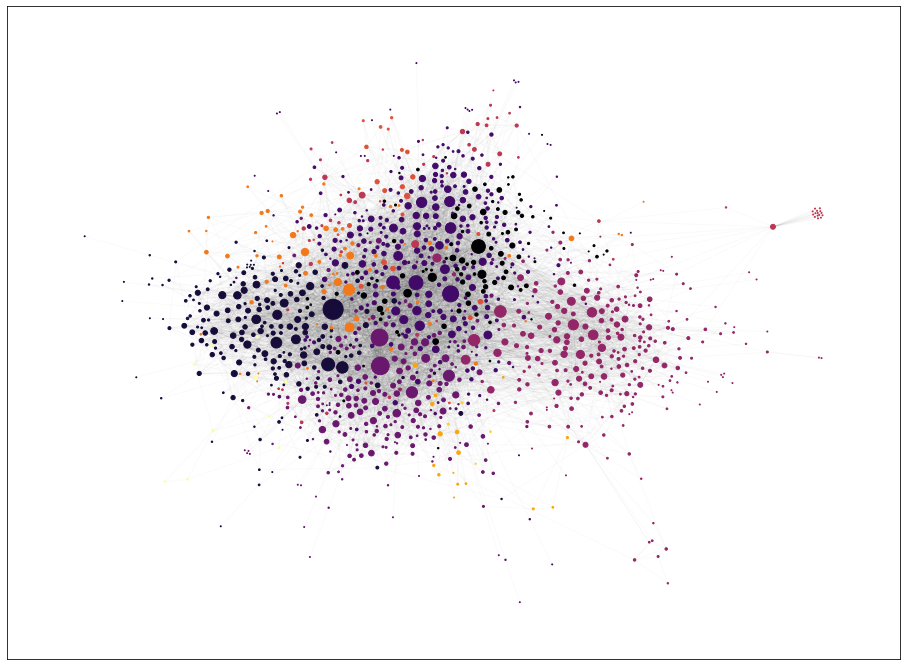

In [ ]:
# Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

plt.figure(figsize=(16, 12))
cmap = cm.get_cmap("inferno", max(partition.values()) + 1)
nx.draw_networkx_nodes(
    marvel_subgraph, positions, node_size=node_size,
    cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(marvel_subgraph, positions, alpha=0.02)
plt.show()


### For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

In [ ]:
def clean_text(text):
  """ 
  1) Tokenize the pages into individual strings
  2) Remove all punctuation from your list of tokens
  3) Set everything to lower case
  4) Lemmatize your words 
  """
  text = [word.lower() for word in text if word != '']
  stop_words = stopwords.words('english')
  stop_words.extend(string.punctuation)
  stop_words.extend(["--", "``", "''", "ref", "/ref","'s", "br/", "br", "==", "the", "''"])
  text = [word.replace("|", "") for word in text]
  text = [word for word in text if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(word) for word in text]
  return text

In [ ]:
# Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). 
# Remember to comment on your word-clouds (e.g. in the figure captions): 
# Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [ ]:
communities = defaultdict(list)
for member, community in partition.items():
    file_ = f"marvel/{member}.txt"
    if not os.path.exists(file_):
        print(f"{file_} does not exist")
        continue
    with open(file_, "r", encoding="utf-8") as ofile:
        content = ofile.read()
        tokens = nltk.tokenize.word_tokenize(content)
        communities[community].extend(clean_text(tokens))

In [ ]:
# Term frequency for each document in given text 

def term_freq(text):
    term_freqs = defaultdict(int)
    for word in text:
        term_freqs[word] += 1/len(text)
    return term_freqs


In [ ]:
# Calculate inverse document frequency for each word in a corpus 

def inv_doc_freq(corpus):

    words_idf = {}
    words_count = defaultdict(int)
    for text in corpus:
        words_in_text = set()
        for word in text:
            if word not in words_in_text:
                words_in_text.add(word)
                words_count[word] += 1
    
    for word, count in words_count.items():
        words_idf[word] = np.log(len(corpus) / (1 + words_count[word]))
    
    return words_idf


In [ ]:
term_freqs = []
for comm, text in communities.items():
    term_freqs.append(term_freq(text))

In [ ]:
corpus = [text for text in communities.values()]
idf = inv_doc_freq(corpus)

In [ ]:
tfidf_by_comm = []
for comm in term_freqs:
    tfidf = []
    for word, tf in comm.items():
        tfidf.append((word, tf * idf[word]))
    # append sorted tfidf per community in descending order
    # this is useful for listing
    # wordcloud doesn't care about the order
    tfidf_by_comm.append(sorted(tfidf, key=lambda x: x[1], reverse=True))

<Figure size 432x288 with 0 Axes>

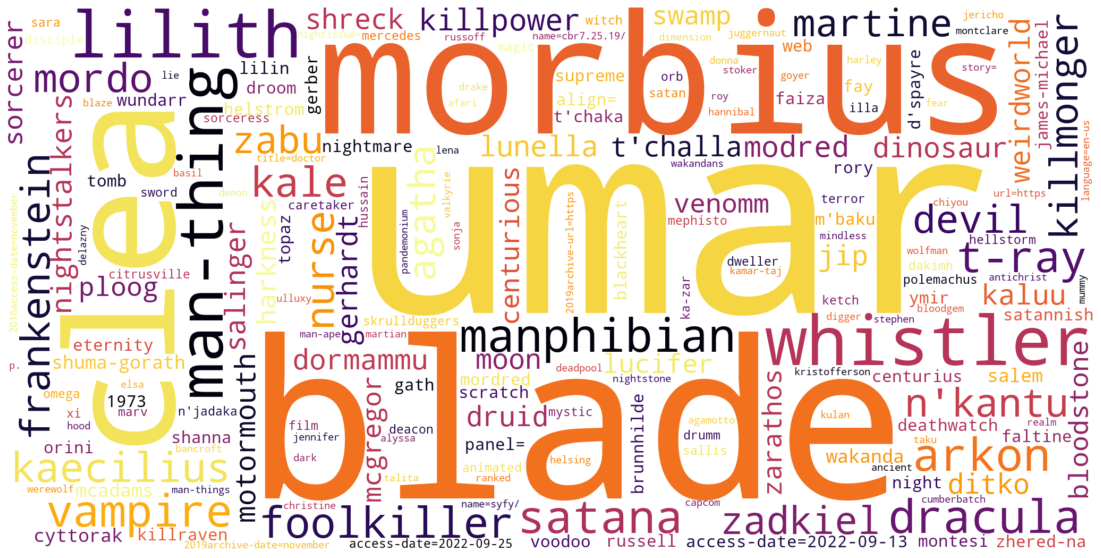

<Figure size 432x288 with 0 Axes>

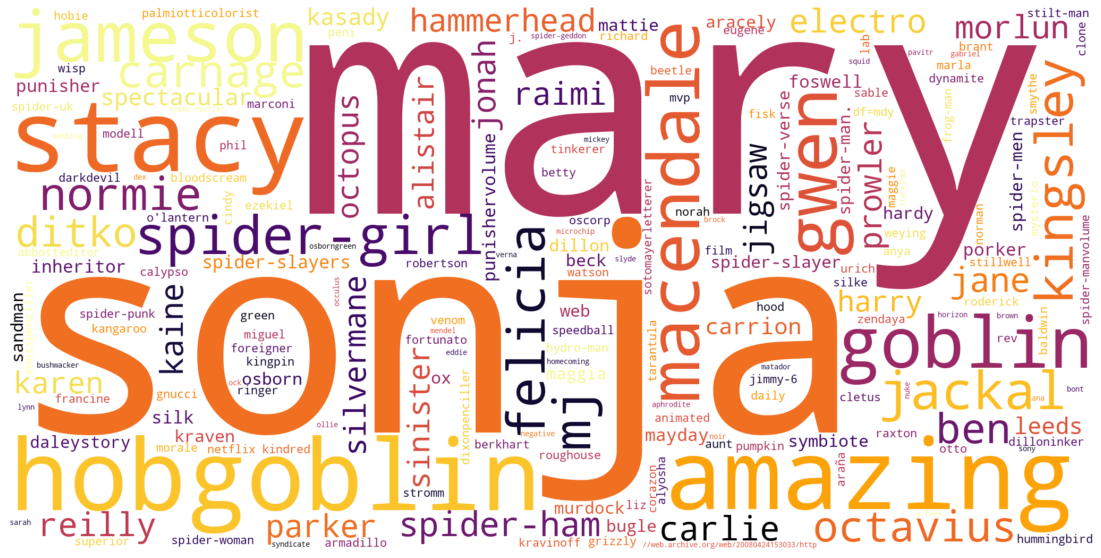

<Figure size 432x288 with 0 Axes>

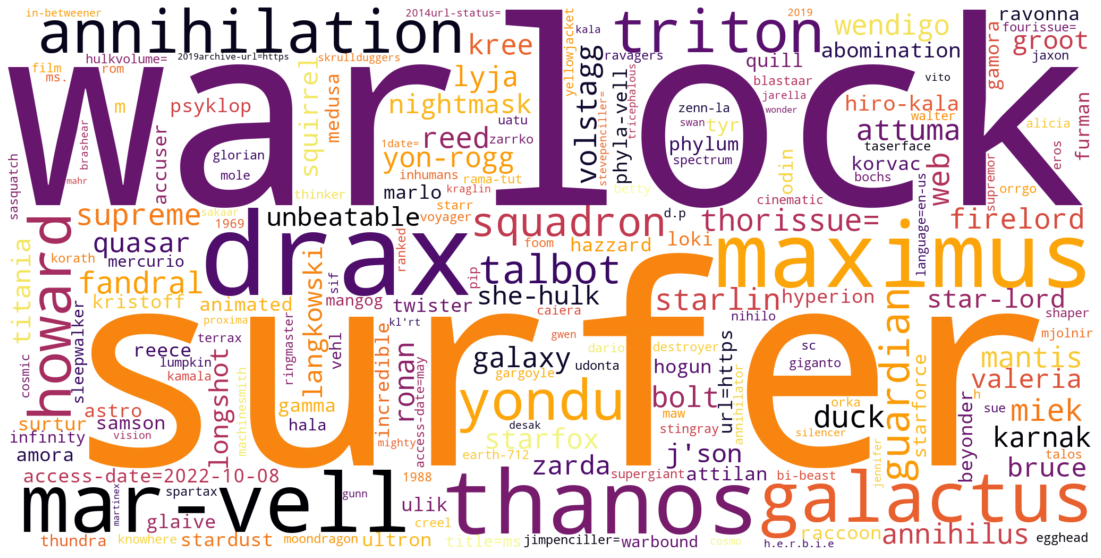

<Figure size 432x288 with 0 Axes>

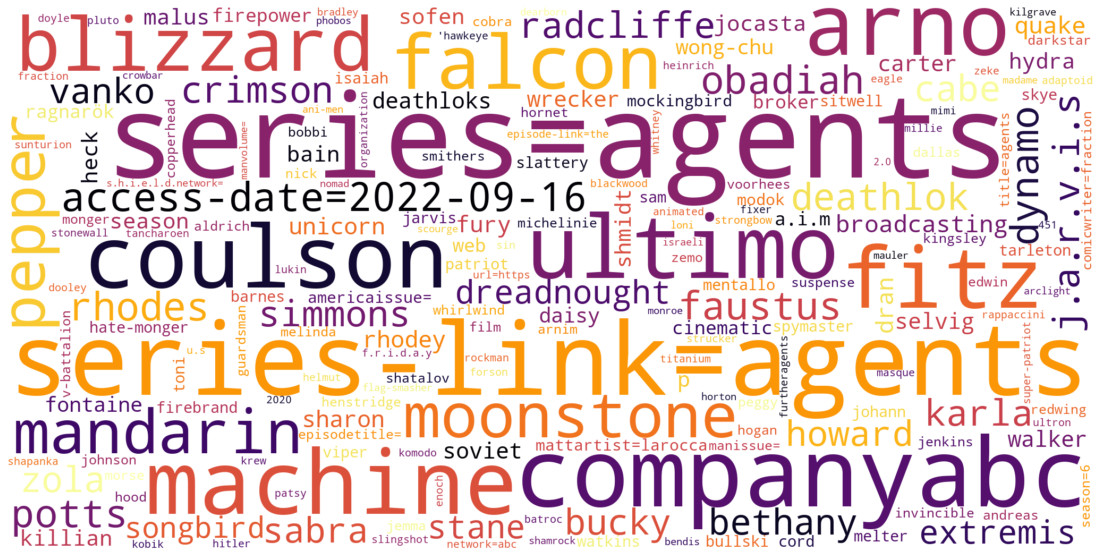

<Figure size 432x288 with 0 Axes>

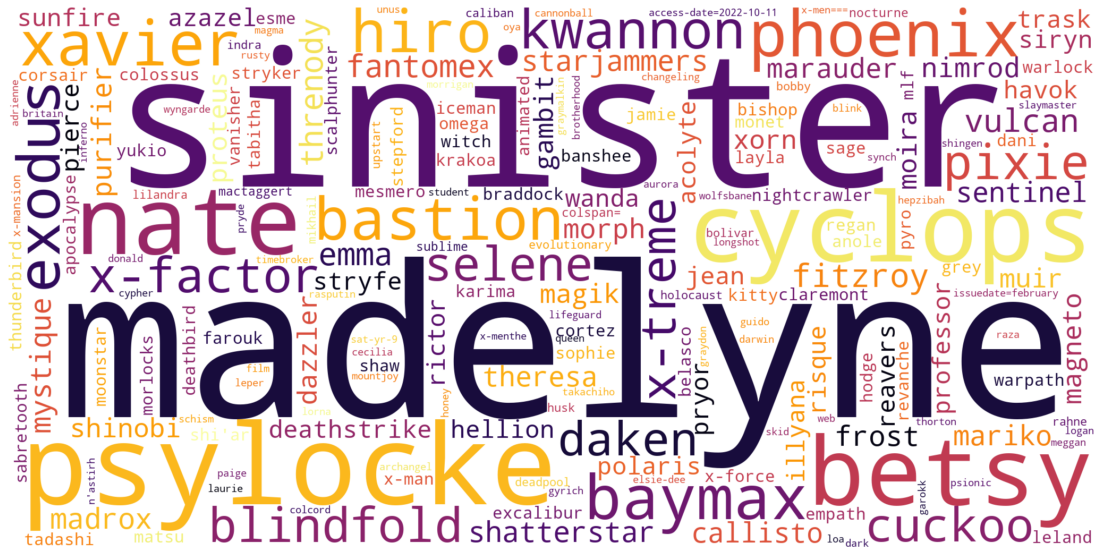

<Figure size 432x288 with 0 Axes>

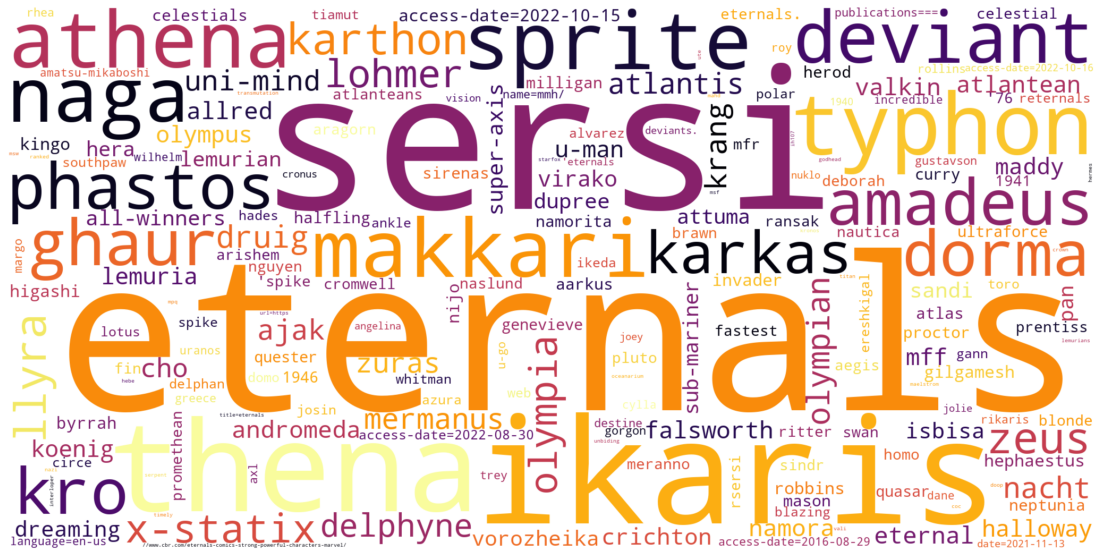

<Figure size 432x288 with 0 Axes>

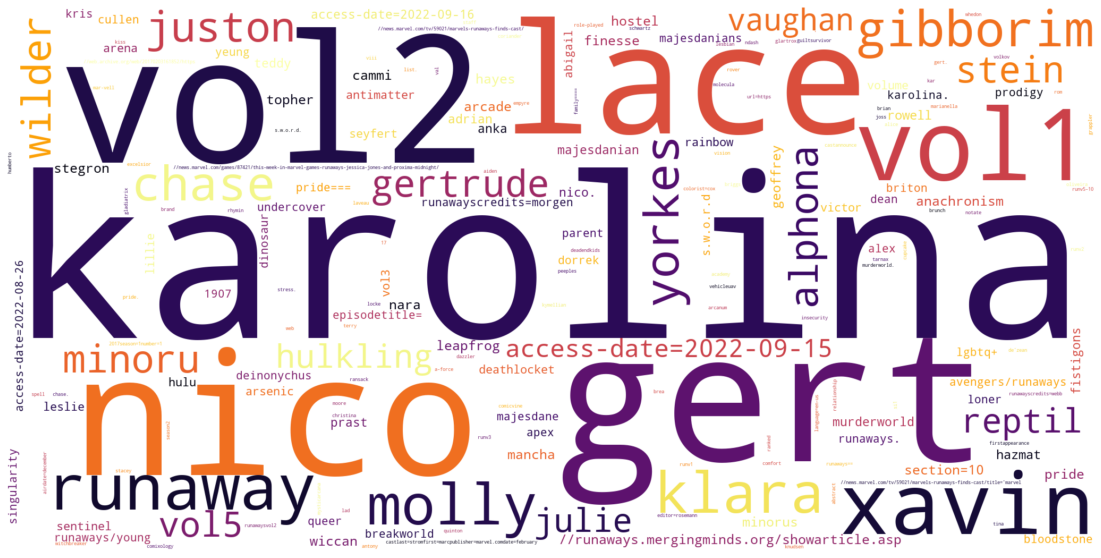

<Figure size 432x288 with 0 Axes>

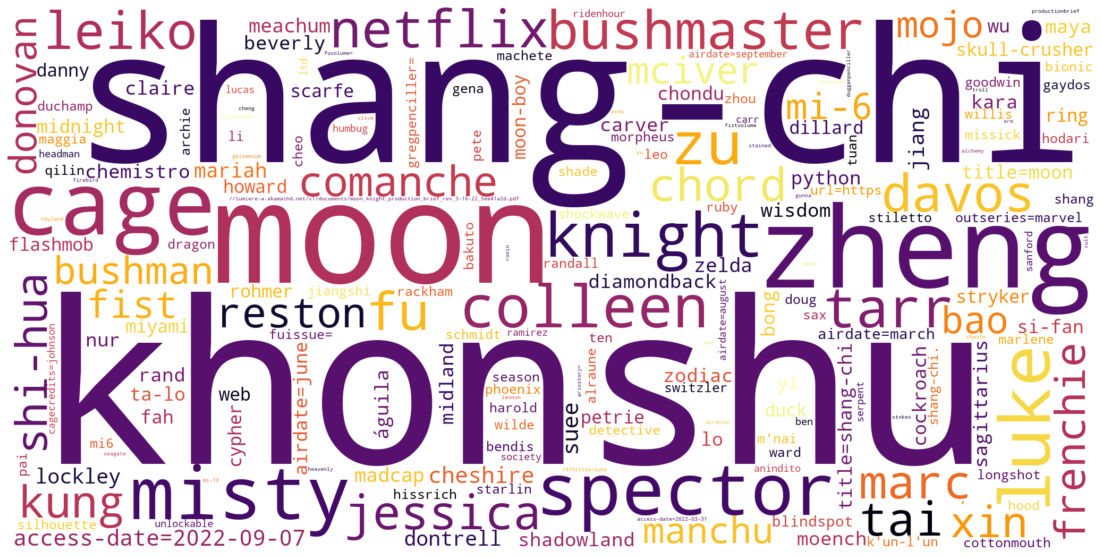

<Figure size 432x288 with 0 Axes>

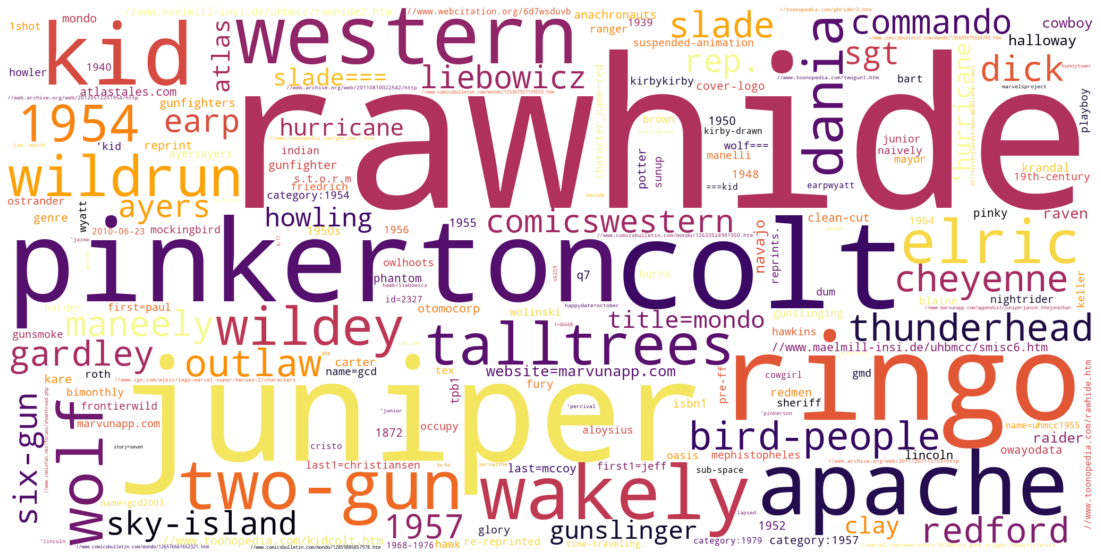

<Figure size 432x288 with 0 Axes>

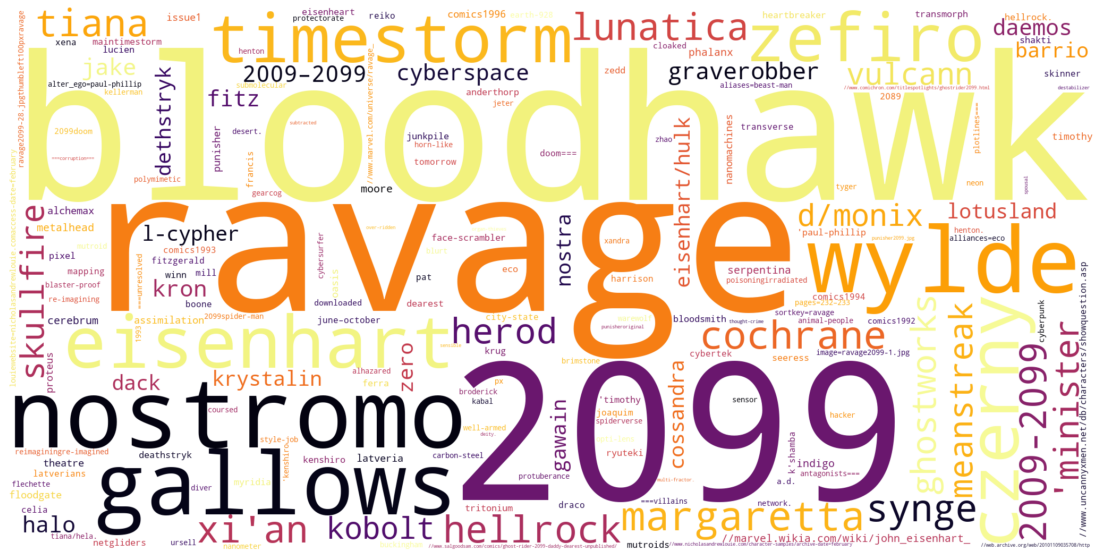

<Figure size 432x288 with 0 Axes>

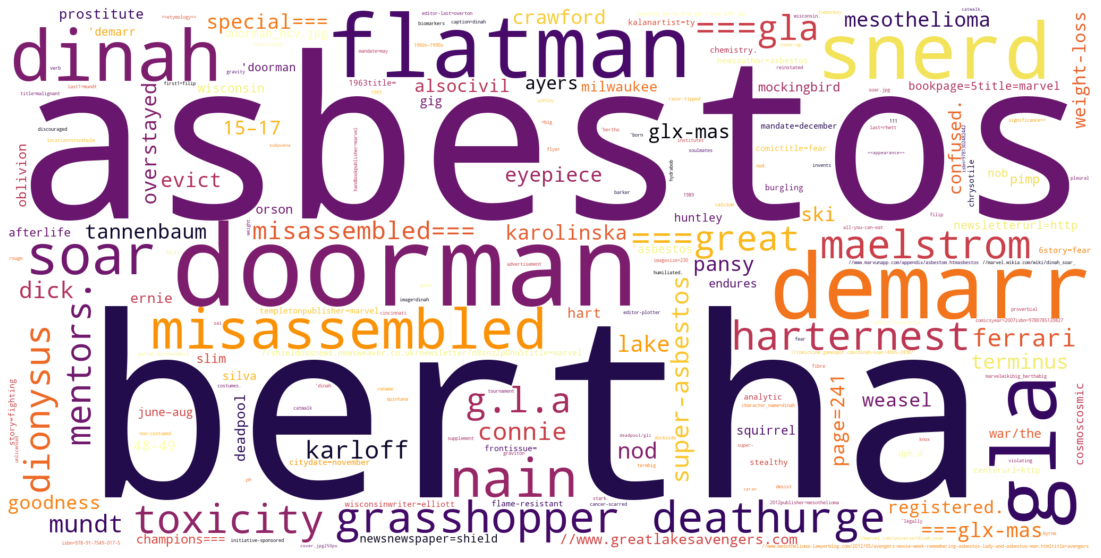

In [ ]:
for comm in tfidf_by_comm:
    plt.clf()
    plt.figure(figsize=(20, 10))
    wordcloud_dc = WordCloud(
        collocations=False,
        background_color="white",
        colormap="inferno", 
        width=2048,
        height=1024,
        ).generate_from_frequencies(dict(comm))
    plt.imshow(wordcloud_dc, interpolation='bilinear')
    plt.axis("off")
    plt.show()